In [1]:
import os
from utils import load_jsonl_iteratively, load_jsonl
from memorization_analysis.utils import get_model_loss

In [2]:
from tqdm import tqdm
ja_mem_id2losses, ja_gen_id2losses, en2ja_gen_id2losses = {}, {}, {}
for i in tqdm(range(0, 17000, 1000)):
    i = 'last' if i == 16000 else i
    id2loss = get_model_loss("ja", "generalization", i)
    for sample_id in id2loss:
        id2loss[sample_id]['num_iter'] = i if i != 'last' else 15348
        ja_gen_id2losses.setdefault(sample_id, []).append(id2loss[sample_id])
    
    id2loss = get_model_loss("ja", "memorization", i)
    for sample_id in id2loss:
        id2loss[sample_id]['num_iter'] = i if i != 'last' else 15348
        ja_mem_id2losses.setdefault(sample_id, []).append(id2loss[sample_id])

    id2loss = get_model_loss("ja", "generalization", i, crosslang=True)
    for sample_id in id2loss:
        id2loss[sample_id]['num_iter'] = i if i != 'last' else 15348
        en2ja_gen_id2losses.setdefault(sample_id, []).append(id2loss[sample_id])


from tqdm import tqdm
en_mem_id2losses, en_gen_id2losses, ja2en_gen_id2losses = {}, {}, {}
for i in tqdm(range(0, 17000, 1000)):
    i = 'last' if i == 16000 else i
    id2loss = get_model_loss("en", "generalization", i)
    for sample_id in id2loss:
        id2loss[sample_id]['num_iter'] = i if i != 'last' else 15348
        en_gen_id2losses.setdefault(sample_id, []).append(id2loss[sample_id])
    
    id2loss = get_model_loss("en", "memorization", i)
    for sample_id in id2loss:
        id2loss[sample_id]['num_iter'] = i if i != 'last' else 15348
        en_mem_id2losses.setdefault(sample_id, []).append(id2loss[sample_id])
    
    id2loss = get_model_loss("en", "generalization", i, crosslang=True)
    for sample_id in id2loss:
        id2loss[sample_id]['num_iter'] = i if i != 'last' else 15348
        ja2en_gen_id2losses.setdefault(sample_id, []).append(id2loss[sample_id])

100%|██████████| 17/17 [00:07<00:00,  2.20it/s]


In [6]:
do_filtering = True

import numpy as np
def analyize(title, id2loss):
    forget, acquired, keepin, keepout = 0, 0, 0, 0
    for sample_id, losses in list(id2loss.items()):
        init_match = losses[0]['answer_idx'] == np.asarray(losses[0]['norm_loss']).argmin()
        final_match = losses[-1]['answer_idx'] == np.asarray(losses[-1]['norm_loss']).argmin()
        if init_match and final_match:
            keepin += 1
        elif init_match and (not final_match):
            forget += 1
        elif (not init_match) and final_match:
            acquired += 1
        else:
            keepout += 1

    print(f"------- {title} -------")
    # print(f"Forget: {forget}, Acquired: {acquired}, Keep In: {keepin}, Keep Out: {keepout}, all: {len(id2loss)}")
    print(f"Forget: {forget/len(id2loss):.3%}, Acquired: {acquired/len(id2loss):.3%}, Keep In: {keepin/len(id2loss):.3%}, Keep Out: {keepout/len(id2loss):.3%}")
            

analyize("Japanese memorization: ", ja_mem_id2losses)
analyize("Japanese generalization: ", ja_gen_id2losses)
analyize("English to Japanese transfer: ", en2ja_gen_id2losses)

analyize("English memorization: ", en_mem_id2losses)
analyize("English generalization: ", en_gen_id2losses)
analyize("Japanese to English transfer: ", ja2en_gen_id2losses)

------- Japanese memorization:  -------
Forget: 3.682%, Acquired: 33.882%, Keep In: 41.990%, Keep Out: 20.447%
------- Japanese generalization:  -------
Forget: 4.152%, Acquired: 23.032%, Keep In: 30.787%, Keep Out: 42.029%
------- English to Japanese transfer:  -------
Forget: 9.205%, Acquired: 12.730%, Keep In: 25.734%, Keep Out: 52.331%
------- English memorization:  -------
Forget: 3.677%, Acquired: 27.132%, Keep In: 32.447%, Keep Out: 36.743%
------- English generalization:  -------
Forget: 4.110%, Acquired: 26.143%, Keep In: 28.585%, Keep Out: 41.162%
------- Japanese to English transfer:  -------
Forget: 7.509%, Acquired: 10.569%, Keep In: 25.185%, Keep Out: 56.737%


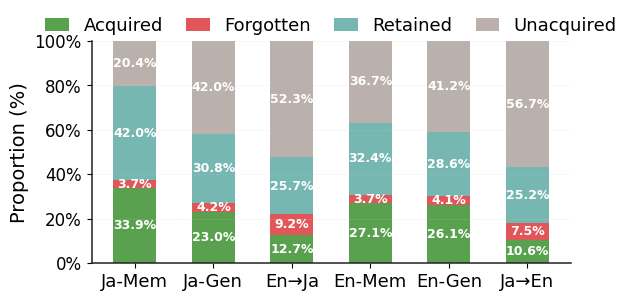

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter

# Data
titles = ["Ja-Mem", "Ja-Gen", "En→Ja", "En-Mem", "En-Gen", "Ja→En"]
forgotten =  np.array([3.682, 4.152, 9.205, 3.677, 4.110, 7.509])
acquired  =  np.array([33.882, 23.032, 12.730, 27.132, 26.143, 10.569])
retained  =  np.array([41.990, 30.787, 25.734, 32.447, 28.585, 25.185])
unacquired = np.array([20.447, 42.029, 52.331, 36.743, 41.162, 56.737])

# Matplotlib styling
plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 11.5,
    "axes.labelsize": 12,
    "axes.titlesize": 13.5,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.linewidth": 1.1,
    "axes.edgecolor": "#222222",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.color": "#cccccc",
    "grid.linestyle": "--",
    "grid.linewidth": 0.6,
    "legend.fontsize": 12,
})

# Colors (color-blind-safe)
colors = {
    "Acquired": "#59a14f",     # green
    "Forgotten": "#e15759",    # red
    "Retained": "#76b7b2",     # blue
    "Unacquired": "#bab0ac"    # gray
}

# Figure setup
fig, ax = plt.subplots(figsize=(6.4, 3.2))
x = np.arange(len(titles))

# Compute cumulative bottoms
bottom_acq = np.zeros_like(acquired)
bottom_fgt = acquired
bottom_ret = acquired + forgotten
bottom_unq = acquired + forgotten + retained

# Stacked bars
bars_acq = ax.bar(x, acquired, color=colors["Acquired"], label="Acquired", width=0.55)
bars_fgt = ax.bar(x, forgotten, bottom=bottom_fgt, color=colors["Forgotten"], label="Forgotten", width=0.55)
bars_ret = ax.bar(x, retained, bottom=bottom_ret, color=colors["Retained"], label="Retained", width=0.55)
bars_unq = ax.bar(x, unacquired, bottom=bottom_unq, color=colors["Unacquired"], label="Unacquired", width=0.55)

# Add percentage labels
def add_labels(bars, values, bottoms):
    for bar, val, bot in zip(bars, values, bottoms):
        if val > 2:  # only label if segment > 2%
            ax.text(
                bar.get_x() + bar.get_width()/2, bot + val/2,
                f"{val:.1f}%", ha="center", va="center",
                fontsize=9, color="white", fontweight="bold"
            )

add_labels(bars_acq, acquired, bottom_acq)
add_labels(bars_fgt, forgotten, bottom_fgt)
add_labels(bars_ret, retained, bottom_ret)
add_labels(bars_unq, unacquired, bottom_unq)

# Axis setup
ax.set_xticks(x)
ax.set_xticklabels(titles, fontsize=13)
ax.set_ylim(0, 100)
ax.set_ylabel("Proportion (%)", fontsize=14, labelpad=4)
ax.yaxis.set_major_formatter(PercentFormatter(100))
ax.grid(axis="y", alpha=0.25)

# Legend
ax.legend(
    ncol=4, frameon=False, loc="upper center", fontsize=13,
    bbox_to_anchor=(0.5, 1.18), handlelength=1.3, columnspacing=1.3
)

# Layout & save
plt.tight_layout()
plt.savefig("../figures/instance_analysis_stacked_bar.pdf", dpi=300, bbox_inches="tight")
plt.show()
